In [ ]:
from IPython.display import HTML

In [ ]:
HTML(
    '''
    <script>
    code_show=true; 
    function code_toggle() {
     if (code_show){
     $('div.input').hide();
     } else {
     $('div.input').show();
     }
     code_show = !code_show
    } 
    $( document ).ready(code_toggle);
    </script>
    <a href="javascript:code_toggle()">TOGGLE CODE ON/OFF</a>
    '''
)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Sanity-checks-on-motion-energy" data-toc-modified-id="Sanity-checks-on-motion-energy-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Sanity checks on motion energy</a></span></li></ul></div>

__Aims:__
- reads off trials from the HDF5 db in order to compute motion energy
- explore a few statistics of ME within groups of trials (e.g. 0-coh trials)
- plots reverse kernels

Constants and settings

In [1]:
import sys

# add location of custom modules to path
sys.path.insert(0,'../modules/')
sys.path.insert(0,'../modules/dots_db/dotsDB/')

# add location of data to path -- I couldn't make this work
# sys.path.insert(0,'../../data/')
# sys.path.insert(0,'../modules/dots_db/data/')

In [2]:
# pip modules
import pprint
import numpy as np             
import pandas as pd    
import seaborn as sns
import matplotlib.pyplot as plt
import h5py     

# custom modules
import dotsDB as ddb
import motionenergy as kiani_me
import stimulus as stim
import ME_functions as my_me

In [3]:
# OPTIONS AND CONSTANTS
%matplotlib inline

sns.set(style="darkgrid", context="poster")
TITLE_FS = 22
AXES_FS = 22
plt.rcParams.update({'font.size': AXES_FS}) # font size on axes
plt.subplots_adjust(wspace=0.5) # horizontal space between panels

SKIP_BASIC_STEPS = False

<Figure size 432x288 with 0 Axes>

Load all group and dataset names in DB

In [4]:
file_path = '/home/adrian/SingleCP_DotsReversal/processed/pilot_v3.h5'
object_names, database_info = my_me.get_object_names_in_db(file_path)

In [5]:
pprint.pprint(object_names)

['subjS1/probCP0.0/coh0.0/ansleft/CPno/VD100/left',
 'subjS1/probCP0.0/coh0.0/ansleft/CPno/VD100/left/px',
 'subjS1/probCP0.0/coh0.0/ansleft/CPno/VD100/right',
 'subjS1/probCP0.0/coh0.0/ansleft/CPno/VD100/right/px',
 'subjS1/probCP0.0/coh0.0/ansleft/CPno/VD200/left',
 'subjS1/probCP0.0/coh0.0/ansleft/CPno/VD200/left/px',
 'subjS1/probCP0.0/coh0.0/ansleft/CPno/VD200/right',
 'subjS1/probCP0.0/coh0.0/ansleft/CPno/VD200/right/px',
 'subjS1/probCP0.0/coh0.0/ansleft/CPno/VD300/left',
 'subjS1/probCP0.0/coh0.0/ansleft/CPno/VD300/left/px',
 'subjS1/probCP0.0/coh0.0/ansleft/CPno/VD300/right',
 'subjS1/probCP0.0/coh0.0/ansleft/CPno/VD300/right/px',
 'subjS1/probCP0.0/coh0.0/ansleft/CPno/VD400/left',
 'subjS1/probCP0.0/coh0.0/ansleft/CPno/VD400/left/px',
 'subjS1/probCP0.0/coh0.0/ansleft/CPno/VD400/right',
 'subjS1/probCP0.0/coh0.0/ansleft/CPno/VD400/right/px',
 'subjS1/probCP0.0/coh0.0/ansright/CPno/VD100/left',
 'subjS1/probCP0.0/coh0.0/ansright/CPno/VD100/left/px',
 'subjS1/probCP0.0/coh0.0/a

Now, I will need to group datasets by factor values. Examples of grouping are:
- 0-coh trials with true direction L vs R, VD 400, CP vs noCP

22 22
num of trials 287
min # of frames 24
             ME  coherence  density direction                   dsetID  \
0 -1.278117e-30        0.0       90      left  coh0dirleftvd400cpFalse   
1  2.305715e-06        0.0       90      left  coh0dirleftvd400cpFalse   
2  3.877212e+00        0.0       90      left  coh0dirleftvd400cpFalse   
3  1.964579e+01        0.0       90      left  coh0dirleftvd400cpFalse   
4  2.307056e+01        0.0       90      left  coh0dirleftvd400cpFalse   

                             filtersID      time  trial  
0  32_32_11_32_32_11_32_32_11_32_32_11  0.000000      1  
1  32_32_11_32_32_11_32_32_11_32_32_11  0.016667      1  
2  32_32_11_32_32_11_32_32_11_32_32_11  0.033333      1  
3  32_32_11_32_32_11_32_32_11_32_32_11  0.050000      1  
4  32_32_11_32_32_11_32_32_11_32_32_11  0.066667      1  


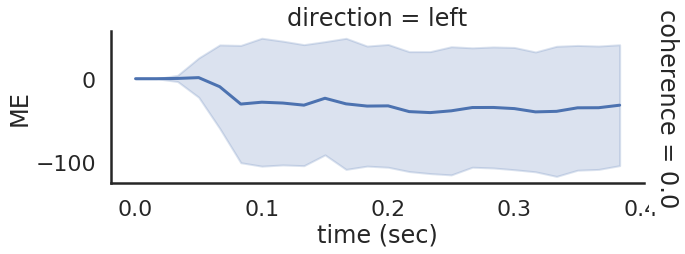

In [6]:
"""
recall maps in my_me.get_group_names()

{'ans': {'l': 'ansleft', 'r': 'ansright'},
 'coh': {0: 'coh0.0',
         100: 'coh100.0',
         'fcn': <function <lambda> at 0x7fd422cf08c8>},
 'cp': {False: 'CPno', True: 'CPyes'},
 'dir': {'left': '/left', 'right': '/right'},
 'pcp': {0: 'probCP0.0', 0.2: 'probCP0.2', 0.5: 'probCP0.5', 0.8: 'probCP0.8'},
 'subject': {1: 'subjS1', 2: 'subjS2', 3: 'subjS3', 4: 'subjS4', 5: 'subjS5'},
 'vd': {100: 'VD100', 200: 'VD200', 300: 'VD300', 400: 'VD400'}}
"""

# here I define a specific dataset that I want to extract
dset_def = {
    'coh': [0],
    'dir': ['left'],
    'vd': [400],
    'cp': [False]    
}
group_names, dset_names = my_me.get_names(dset_def, object_names)
print(len(dset_names),len(group_names))
dots = my_me.extract_list_arrays(group_names, dset_names, 50, file_path)
print('num of trials', len(dots))
# truncate to minimum number of frames
min_num_frames = min(k.shape[2] for k in dots)
print('min # of frames', min_num_frames)
dots = [d[:,:,:min_num_frames] for d in dots]
# pprint.pprint([d.shape for d in dots])
agg_df = my_me.build_me_df(database_info, group_names, dots, dset_def)
print(agg_df.head())

# PLOT
# somehow in this cell I had to call again these 3 commands
plt.rcParams["figure.figsize"] = (16, 25) # (w, h) # figure size 

with sns.axes_style("white"):
    g = sns.FacetGrid(agg_df, row="coherence", col="direction", margin_titles=True, height=4, aspect=2.5)
g.map(sns.lineplot, "time", "ME", ci="sd");
g.set_axis_labels("time (sec)", "ME");
# g.set(xticks=[10, 30, 50], yticks=[2, 6, 10]);
# g.fig.subplots_adjust(wspace=20, hspace=.2);def build_me_df(database_info, group_names, dots):

20 20
num of trials 190
min # of frames 24
             ME  coherence  density direction                    dsetID  \
0 -2.502993e-31        0.0       90     right  coh0dirrightvd400cpFalse   
1 -5.279515e-06        0.0       90     right  coh0dirrightvd400cpFalse   
2 -1.240889e+00        0.0       90     right  coh0dirrightvd400cpFalse   
3 -2.789583e+00        0.0       90     right  coh0dirrightvd400cpFalse   
4 -1.138999e+00        0.0       90     right  coh0dirrightvd400cpFalse   

                             filtersID      time  trial  
0  32_32_11_32_32_11_32_32_11_32_32_11  0.000000      1  
1  32_32_11_32_32_11_32_32_11_32_32_11  0.016667      1  
2  32_32_11_32_32_11_32_32_11_32_32_11  0.033333      1  
3  32_32_11_32_32_11_32_32_11_32_32_11  0.050000      1  
4  32_32_11_32_32_11_32_32_11_32_32_11  0.066667      1  


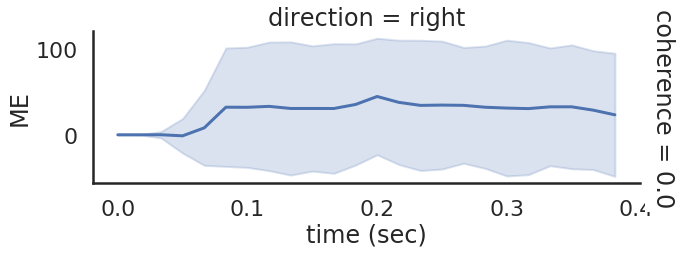

In [7]:
# here I define a specific dataset that I want to extract
dset_def2 = {
    'coh': [0],
    'dir': ['right'],
    'vd': [400],
    'cp': [False]    
}
group_names, dset_names = my_me.get_names(dset_def2, object_names)
print(len(dset_names),len(group_names))
dots = my_me.extract_list_arrays(group_names, dset_names, 50, file_path)
print('num of trials', len(dots))
# truncate to minimum number of frames
min_num_frames = min(k.shape[2] for k in dots)
print('min # of frames', min_num_frames)
dots = [d[:,:,:min_num_frames] for d in dots]
# pprint.pprint([d.shape for d in dots])
agg_df2 = my_me.build_me_df(database_info, group_names, dots, dset_def2)
print(agg_df2.head())

# PLOT
# somehow in this cell I had to call again these 3 commands
plt.rcParams["figure.figsize"] = (16, 25) # (w, h) # figure size 

with sns.axes_style("white"):
    g = sns.FacetGrid(agg_df2, row="coherence", col="direction", margin_titles=True, height=4, aspect=2.5)
g.map(sns.lineplot, "time", "ME", ci="sd");
g.set_axis_labels("time (sec)", "ME");

Applying energy filters below. For 287 trials of 24 frames each, took a bit under a minute!

`dots_energy` is a list of numpy arrays with same shape as the original dots frames, i.e. `(152,152,24)`

# Sanity checks on motion energy

- display ME (averaged across trials), for a whole dataset, add stdev on top of mean.
- repeat the above for the opposite direction of motion (new dataset)
- repeat the above for several coherence levels  

**Steps**   
1. get motion energies in data frame
2. plot results with seaborn

With 100 trials, ME sould take, max, 2min to compute...

In [ ]:
LOAD_DATA_FRAME = False  # if true, should load csv file dumped in previous cell



In [ ]:
# same for ansright


In [ ]:
# time_next_cell = 4
# print(f"WARNING, THE NEXT CELL TAKES SOME TIME TO EXECUTE. LAST TIME IT TOOK {time_next_cell} MINUTES")

In [ ]:
# %%time
RUN = False
if RUN:
    print(f"applying filters to {len(dset_names)} datasets")
    df_list=[]
    for (dsetname, gname) in zip(dset_names, group_names):
        trial_list = range(1, database_info[dsetname[1:]]['shape'][0] + 1)
        df_list.append(my_me.compute_motion_energy_for_trials_in_db(file_path, dsetname[1:], gname[1:], 
                                                                    trial_list, filters, create_dsetid=False)) 
else:
    print(f"As a safeguard, this cell didn't execute. Set the RUN variable to True if you really want to execute it.")

In [ ]:
print("INFO ABOUT AGGREGATE DATA FRAME")
agg_df.info()

In [ ]:
agg_df['ME'].describe()

In [ ]:
agg_df.groupby('time')['ME'].describe()

In [ ]:
# import re

In [ ]:
# ansleft_pattern = r"ansleft"
# probCP_low_pattern = r"probCP0.1"
# subj_patterns = [r"subj" + str(pilotID) for pilotID in range(15,20)]
# print(subj_patterns)

In [ ]:
agg_df.shape

In [ ]:
# a=agg_df["dsetID"].values[0]
# print(a)

In [ ]:
# type(a)

In [ ]:
# newcol_names = ['ansdir', 'subject', 'probCP']
# ansdir, subject, probCP = [], [], []
# for r in range(agg_df.shape[0]):
#     dset_name = agg_df['dsetID'].values[r]
#     ans_match = re.search(ansleft_pattern, dset_name)
#     prob_match = re.search(probCP_low_pattern, dset_name)
#     subj_matches = [re.search(subj_pattern, dset_name) for subj_pattern in subj_patterns]
    
#     if ans_match:
#         ansdir.append('left')
#     else:
#         ansdir.append('right')
        
#     if prob_match:
#         probCP.append(0.1)
#     else:
#         probCP.append(0.5)
        
#     for subj in range(len(subj_matches)):
#         subj_match = subj_matches[subj]
#         if subj_match:
#             subject.append(subj + 15)
# assert len(ansdir) == len(subject) == len(probCP)

In [ ]:
# assert len(ansdir) == agg_df.shape[0]

In [ ]:
# agg_df["ansdir"] = ansdir
# agg_df["subject"] = subject
# agg_df["probCP"] = probCP

In [ ]:
# agg_df.head()

In [ ]:
# print(f"number of rows in data frame: {len(agg_df)}")

In [ ]:
# FILL_DSET_ID_MANUALLY = False
# if FILL_DSET_ID_MANUALLY: 
#     # since my_me.compute_motion_energy_for_trials_in_db() doesn't yet assign dataset index correctly, I do it manually
#     dsetID_col = 4

#     rows_per_dset = 600
#     num_dsets = len(dset_names)

#     assert len(agg_df) == num_dsets * rows_per_dset

#     idx_low, idx_up = 0, 0

#     for dset_idx in range(num_dsets):
#         idx_up += rows_per_dset
#         agg_df.iloc[idx_low:idx_up,dsetID_col] = 'dset' + str(dset_idx)
#         idx_low = idx_up

In [ ]:
# SAVE_DATAFRAME = False
# file_path = 'motion_energy_pilot_v3.csv'
# if SAVE_DATAFRAME:
#     agg_df.to_csv(file_path, index=False)

In [ ]:
# # same data, but overlayed on single plot
# # nice ref:
# # https://seaborn.pydata.org/generated/seaborn.lineplot.html
# f, axarr = plt.subplots(5, 2, sharex=True, sharey=True)

# plt.rcParams["figure.figsize"] = (14, 20) # (w, h) # figure size 

# palette = sns.color_palette("mako_r", 3)
# probCPs=[.1,.5]

# # Plot the responses for different events and regions
# for subj in range(5):
#     for prob in range(2):
#         subject = subj + 15
#         probCP = probCPs[prob]
#         leg = "brief" if (subj==1 and prob==0) else False
#         sns.lineplot(x="time", y="ME",
#                      data=agg_df[(agg_df["subject"]==subject) & (agg_df["probCP"]==probCP)],
#                      style="ansdir",
#                      palette=palette,
#                      ci="sd", 
#                      legend=leg,
#                      ax=axarr[subj, prob])
#         axarr[subj, prob].set_title(f'subj {subject}; probCP {probCP}')
# for row in range(4):
#     plt.setp([a.get_xticklabels() for a in axarr[row, :]], visible=False)
# plt.setp([a.get_yticklabels() for a in axarr[:, 1]], visible=False)
# plt.tight_layout()
# #         axarr[subj, prob].legend(loc='upper left')